# Notebook pour l'utilisation de BERT en Transfert Learning

### 1 - Importation des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
data_all = pd.read_csv("donnees/donnees_final_sans_doublons.csv")
data = data_all[data_all['Date']!="Date non trouvée"].reset_index()

data

,index,Label,Titre,Date
0,0,culture,Affaire Gérard Depardieu : le parquet de Paris...,2024-08-22T20:40:00+02:00
1,1,culture,"Festival de Deauville 2023 : avec ""Dogman"", Lu...",2023-09-03T12:06:33+02:00
2,4,culture,"""En live, le public doit s'amuser imméd...",2024-06-21T11:44:29+02:00
3,5,culture,De Wes Anderson à la Galerie des offices de Fl...,2024-11-30T13:31:33+01:00
4,6,culture,"""Même les souris vont au paradis"" : un film d’...",2021-06-14T12:32:20+02:00
...,...,...,...,...
6499,7021,sports,Ligue 1 : Lyon maîtrise Saint-Etienne dans le ...,2024-11-10T20:06:00+01:00
6500,7022,sports,Football : le milieu de l'équipe de France You...,2024-08-17T17:00:55+02:00
6501,7023,sports,Football : l'OM officialise l'arrivée d'Adrien...,2024-09-17T18:18:54+02:00
6502,7024,sports,Ligue 1 : le match Nantes-Le Havre interrompu ...,2024-11-24T19:44:29+01:00


In [3]:
label_map = {"culture" :  0, "monde": 1, "meteo": 2, "sante": 3, "politique": 4, "societe": 5, "europe": 6, "environnement": 7, "sports": 8}
inv_label_map = {0: "culture", 1: "monde", 2: "meteo", 3: "sante", 4: "politique", 5: "societe", 6: "europe", 7: "environnement", 8: "sports"}

# Conversion des étiquettes en indices numériques
labels_numeric = [label_map[label] for label in data['Label']]
data['labels_numeric'] = data['Label'].apply(lambda x: label_map[x])
print(len(labels_numeric))

6504


### 2-a - Importation du modèle

In [4]:
from transformers import BertTokenizer,BertForSequenceClassification

model_name = 'distilbert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=9)

max_len = 128
encodings = tokenizer(data['Titre'].astype(str).tolist(), padding=True, truncation=True, max_length=max_len, return_tensors='pt')



/home/tristan/.local/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/tristan/.local/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenc

### 2-b Preprocessing des données

In [5]:
import random
from torch.utils.data import Dataset, DataLoader

class AugmentedTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len, blacklist_words=None, remove_random=False, remove_prob=0.4, shuffle_prob=0.1,
                 train=True):
        """
        Dataset personnalisé pour appliquer des augmentations de texte dynamiques.
        
        Args:
            texts (list of str): Textes bruts.
            labels (list of int): Labels correspondants.
            tokenizer: Tokeniseur (par ex. de transformers).
            max_len (int): Longueur maximale des séquences.
            blacklist_words (list of str): Liste noire de mots à supprimer.
            remove_random (bool): Si True, supprime des mots au hasard.
            remove_prob (float): Fraction de mots à supprimer aléatoirement.
            shuffle_prob (float): Probabilité de mélanger les mots.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.blacklist_words = blacklist_words or []
        self.remove_random = remove_random
        self.remove_prob = remove_prob
        self.shuffle_prob = shuffle_prob
        self.train = train

    def __len__(self):
        return len(self.texts)

    def augment_text(self, text):
        """
        Applique des transformations aléatoires sur un texte.
        """
        if self.train:
            words = text.split()

            # Supprimer les mots de la liste noire
            words = [word for word in words if word.lower() not in self.blacklist_words]

            # Supprimer des mots aléatoirement
            if self.remove_random:
                num_to_remove = int(len(words) * self.remove_prob)
                words = [word for i, word in enumerate(words) if i not in random.sample(range(len(words)), num_to_remove)]

            # Mélanger les mots aléatoirement
            if random.random() < self.shuffle_prob:
                random.shuffle(words)

            return ' '.join(words)
        else:
            return text

    def __getitem__(self, idx):
        """
        Récupère un échantillon transformé et tokenisé.
        """
        text = self.texts[idx]
        label = self.labels[idx]

        # Appliquer des augmentations aléatoires
        augmented_text = self.augment_text(text)

        # Tokenisation
        encoding = self.tokenizer(
            augmented_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].squeeze(0)  # Enlever la dimension batch
        attention_mask = encoding['attention_mask'].squeeze(0)

        return input_ids, attention_mask, label



### 3 - Découpage des données

In [6]:
from sklearn.model_selection import train_test_split


data_sort = data[data['Date']!= "Date non trouvée"].sort_values(by='Date')

test_size = 0.1  
val_size = 0.2  

n_total = len(data_sort)
n_test = int(n_total * test_size)
n_train_val = n_total - n_test
n_val = int(n_train_val * val_size)

# Découper les ensembles
train_data = data_sort.iloc[:n_train_val - n_val]
validation_data = data_sort.iloc[n_train_val - n_val:n_train_val]
test_data = data_sort.iloc[n_train_val:]

# Extraire les textes et les labels
train_texts = train_data['Titre'].astype(str).tolist()
train_labels = train_data['labels_numeric'].tolist()

validation_texts = validation_data['Titre'].astype(str).tolist()
validation_labels = validation_data['labels_numeric'].tolist()

test_texts = test_data['Titre'].astype(str).tolist()
test_labels = test_data['labels_numeric'].tolist()

print(n_total)

blacklist_words = ["au", "du", "le", "la", "les", "un", "une", "et", "ou", "l'", "il"]

# Création des datasets
train_dataset = AugmentedTextDataset(
    texts=train_texts,
    labels=train_labels,
    tokenizer=tokenizer,
    max_len=max_len,
    blacklist_words=blacklist_words,
    remove_random=True,
    remove_prob=0.1,
    shuffle_prob=0.0,
    train=True
)

validation_dataset = AugmentedTextDataset(
    texts=validation_texts,
    labels=validation_labels,
    tokenizer=tokenizer,
    max_len=max_len,
    blacklist_words=None,  
    remove_random=False,
    remove_prob=0,
    shuffle_prob=0,
    train=False
)

test_dataset = AugmentedTextDataset(
    texts=test_texts,
    labels=test_labels,
    tokenizer=tokenizer,
    max_len=max_len,
    blacklist_words=None,  
    remove_random=False,
    remove_prob=0,
    shuffle_prob=0,
    train=False
)

# Création des DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


6504


### 4 - Entrainement du modèle

In [7]:
import torch
from transformers import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

# Vérification de l'availability du GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Déplacer le modèle sur le GPU si disponible
model.to(device)

#Congeler les premières couches du modèle
for param in model.base_model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


# Vérifier les paramètres avant d'exécuter le code
for name, param in model.named_parameters():
    if 'classifier' in name:  # Vérifier spécifiquement les paramètres de la couche classifier
        print(f"Nom : {name}, requires_grad : {param.requires_grad}")

cuda
Nom : classifier.weight, requires_grad : True
Nom : classifier.bias, requires_grad : True


In [8]:
from transformers import AdamW
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Déplacer le modèle sur le GPU

# Optimiseur
optimizer = AdamW(model.parameters(), lr=1e-1)

# Variables pour stocker les pertes
train_losses = []
val_losses = []

# Nombre d'époques
nb_epoch = 30

# Boucle d'entraînement
for epoch in range(nb_epoch):
    print(f"Epoch [{epoch+1}/{nb_epoch}]")
    
    # Phase d'entraînement
    model.train()
    total_train_loss = 0
    train_progress = tqdm(train_dataloader, desc="Training", leave=False)
    
    for batch in train_progress:
        # Déplacer les données sur le GPU
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        # Propagation avant (forward pass)
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask, 
                        labels=labels)
        
        # La perte est automatiquement calculée par le modèle avec CrossEntropyLoss
        loss = outputs.loss
        
        # Rétropropagation (backpropagation)
        loss.backward()
        
        # Optimisation des paramètres du modèle
        optimizer.step()
        optimizer.zero_grad()
        
        # Ajouter la perte de ce batch à la perte totale
        total_train_loss += loss.item()
        
        # Mettre à jour tqdm
        train_progress.set_postfix({"Batch Loss": loss.item()})

    # Calcul de la perte moyenne pour l'entraînement
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Phase de validation
    model.eval()
    total_val_loss = 0
    val_progress = tqdm(validation_dataloader, desc="Validating", leave=False)
    
    with torch.no_grad():  # Désactive la rétropropagation pour économiser de la mémoire
        for batch in val_progress:
            # Déplacer les données sur le GPU
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            # Propagation avant (forward pass)
            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask, 
                            labels=labels)
            
            # La perte de validation
            val_loss = outputs.loss
            total_val_loss += val_loss.item()
            
            # Mettre à jour tqdm
            val_progress.set_postfix({"Batch Loss": val_loss.item()})

    # Calcul de la perte moyenne pour la validation
    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)
    
    # Affichage des pertes
    print(f"Epoch [{epoch+1}/{nb_epoch}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Affichage des courbes de perte d'entraînement et de validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, nb_epoch + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, nb_epoch + 1), val_losses, label='Validation Loss', color='red')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


/home/tristan/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch [1/30]


Epoch [1/30], Train Loss: 9.6372, Validation Loss: 11.8157
Epoch [2/30]


Epoch [2/30], Train Loss: 10.6452, Validation Loss: 8.8581
Epoch [3/30]


Epoch [3/30], Train Loss: 10.6727, Validation Loss: 8.3714
Epoch [4/30]


Epoch [4/30], Train Loss: 10.9725, Validation Loss: 7.5948
Epoch [5/30]


Epoch [5/30], Train Loss: 11.6496, Validation Loss: 9.6494
Epoch [6/30]


Epoch [6/30], Train Loss: 11.8891, Validation Loss: 19.0012
Epoch [7/30]


KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Congeler les premières couches du modèle
for param in model.base_model.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = False


In [ ]:
from transformers import AdamW
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt

# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Déplacer le modèle sur le GPU

# Optimiseur
optimizer = AdamW(model.parameters(), lr=1e-6)

# Variables pour stocker les pertes
train_losses = []
val_losses = []

# Nombre d'époques
nb_epoch = 3

# Boucle d'entraînement
for epoch in range(nb_epoch):
    print(f"Epoch [{epoch+1}/{nb_epoch}]")
    
    # Phase d'entraînement
    model.train()
    total_train_loss = 0
    train_progress = tqdm(train_dataloader, desc="Training", leave=False)
    
    for batch in train_progress:
        # Déplacer les données sur le GPU
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        # Propagation avant (forward pass)
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask, 
                        labels=labels)
        
        # La perte est automatiquement calculée par le modèle avec CrossEntropyLoss
        loss = outputs.loss
        
        # Rétropropagation (backpropagation)
        loss.backward()
        
        # Optimisation des paramètres du modèle
        optimizer.step()
        optimizer.zero_grad()
        
        # Ajouter la perte de ce batch à la perte totale
        total_train_loss += loss.item()
        
        # Mettre à jour tqdm
        train_progress.set_postfix({"Batch Loss": loss.item()})

    # Calcul de la perte moyenne pour l'entraînement
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Phase de validation
    model.eval()
    total_val_loss = 0
    val_progress = tqdm(validation_dataloader, desc="Validating", leave=False)
    
    with torch.no_grad():  # Désactive la rétropropagation pour économiser de la mémoire
        for batch in val_progress:
            # Déplacer les données sur le GPU
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            # Propagation avant (forward pass)
            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask, 
                            labels=labels)
            
            # La perte de validation
            val_loss = outputs.loss
            total_val_loss += val_loss.item()
            
            # Mettre à jour tqdm
            val_progress.set_postfix({"Batch Loss": val_loss.item()})

    # Calcul de la perte moyenne pour la validation
    avg_val_loss = total_val_loss / len(validation_dataloader)
    val_losses.append(avg_val_loss)
    
    # Affichage des pertes
    print(f"Epoch [{epoch+1}/{nb_epoch}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Affichage des courbes de perte d'entraînement et de validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, nb_epoch + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, nb_epoch + 1), val_losses, label='Validation Loss', color='red')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### 5 - Validation du modèle

Validation Loss: 0.8570639320782253


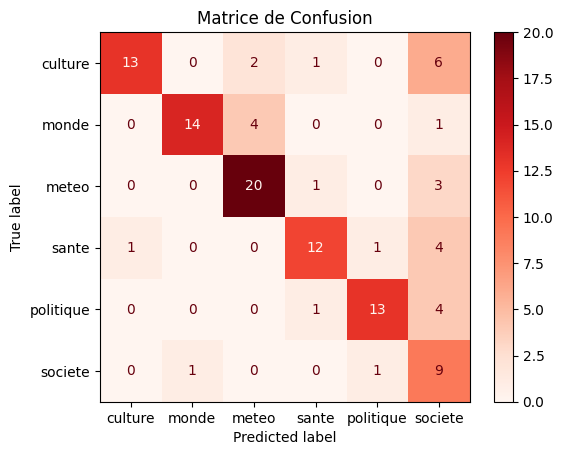

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.cpu()

model.eval()

all_predictions = []
all_labels = []

test_loss = 0
for batch in test_dataloader:
    input_ids, attention_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask, 
                        labels=labels)
        
    test_loss += outputs.loss.item()

    predictions = torch.argmax(outputs.logits, dim=1)
    
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_dataloader)
print(f"Validation Loss: {test_loss}")

all_labels_name= [inv_label_map[x] for x in all_labels]
all_predictions_name = [inv_label_map[x] for x in all_predictions]

# Matrice de confusion
cm = confusion_matrix(all_labels, all_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[inv_label_map[i] for i in range(6)])
display.plot(cmap=plt.cm.Reds)
plt.title("Matrice de Confusion")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score

def calculate_metrics(labels, predictions):
    metrics = {}
    metrics['accuracy'] = accuracy_score(labels, predictions)
    metrics['precision'] = precision_score(labels, predictions, average='weighted')
    metrics['recall'] = recall_score(labels, predictions, average='weighted')
    metrics['f0.5_score'] = fbeta_score(labels, predictions, beta=0.5, average='weighted')
    metrics['f2_score'] = fbeta_score(labels, predictions, beta=2, average='weighted')
    metrics['f1_score'] = fbeta_score(labels, predictions, beta=1, average='weighted')
    
    return metrics

In [ ]:

def calculate_classwise_metrics(labels, predictions):
    
    metrics_per_class = {}
    
    
    for class_index, class_name in inv_label_map.items():
        class_labels = [1 if label == class_index else 0 for label in labels]
        class_predictions = [1 if pred == class_index else 0 for pred in predictions]
        
        metrics_per_class[class_name] = {
            'accuracy': accuracy_score(class_labels, class_predictions),
            'precision': precision_score(class_labels, class_predictions, zero_division=0),
            'recall': recall_score(class_labels, class_predictions, zero_division=0),
            'f1_score': fbeta_score(class_labels, class_predictions, beta=1, zero_division=0),
            'f0.5_score': fbeta_score(class_labels, class_predictions, beta=0.5, zero_division=0),
            'f2_score': fbeta_score(class_labels, class_predictions, beta=2, zero_division=0)
        }
    
    return metrics_per_class

def display_classwise_metrics(metrics_per_class):
    
    class_names = list(metrics_per_class.keys())
    metric_names = ['accuracy','precision', 'recall', 'f1_score', 'f0.5_score', 'f2_score']
    
    donnees = np.array([[metrics_per_class[cls][metric] for metric in metric_names] for cls in class_names])
    num_classes, num_metrics = donnees.shape
    
    x = np.arange(num_metrics) 
    width = 0.8 / num_classes
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for i in range(num_classes):
        ax.bar(x + i * width, donnees[i], width, label=class_names[i])
    
    ax.set_title("Métriques par Classe", fontsize=16)
    ax.set_xticks(x + width * (num_classes - 1) / 2)
    ax.set_xticklabels(metric_names, fontsize=12)
    ax.set_ylabel("Score", fontsize=14)
    ax.set_ylim(0, 1)  
    ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


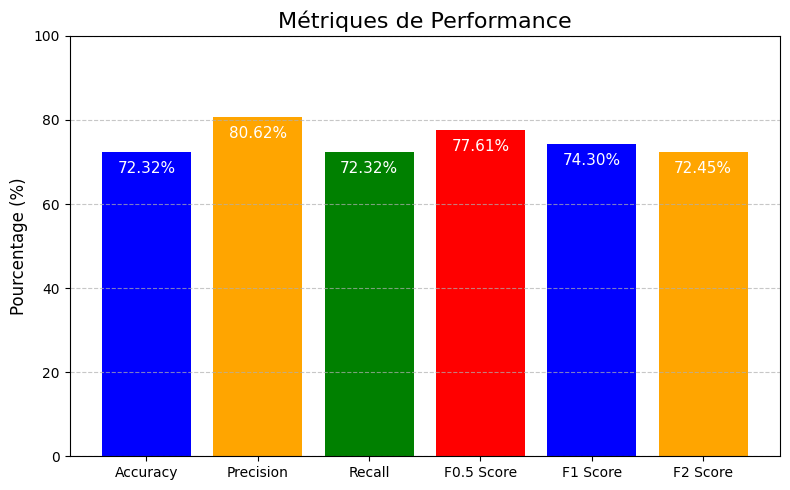

In [ ]:
metrics = calculate_metrics(all_labels, all_predictions)

metric_names = ['Accuracy', 'Precision', 'Recall', 'F0.5 Score', 'F1 Score', 'F2 Score']
metric_values = [
    metrics['accuracy'] * 100,
    metrics['precision'] * 100,
    metrics['recall'] * 100,
    metrics['f0.5_score'] * 100,
    metrics['f1_score'] * 100,
    metrics['f2_score'] * 100
]

plt.figure(figsize=(8, 5))
bars = plt.bar(metric_names, metric_values, color=['blue', 'orange', 'green', 'red'])
for bar, value in zip(bars, metric_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5,
             f"{value:.2f}%", ha='center', color='white', fontsize=11)

plt.title("Métriques de Performance", fontsize=16)
plt.ylabel("Pourcentage (%)", fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


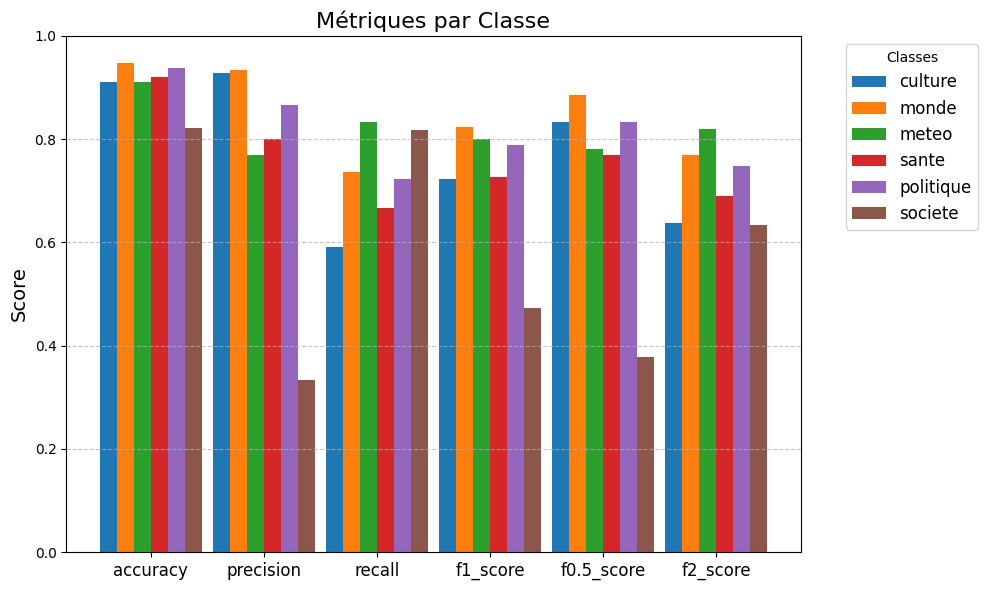

In [ ]:
display_classwise_metrics(calculate_classwise_metrics(all_labels, all_predictions))